### Patient classification

# 1. Cargar librerias y set de datos

In [1]:
import pandas as pd
import mlxtend as mx
import numpy as np

In [2]:
train = pd.read_csv("./data/train_dataset_pred.csv")
train.set_index("patient_id", inplace = True)
train = train.drop(train.columns[0], axis = 1)

Cabecera de nuestra base de entrenamiento

In [3]:
train.head(10)

,height,weight,sys_volume_RV_mL,sys_volume_LV_mL,sys_volume_Myo_mL,dia_volume_RV_mL,dia_volume_LV_mL,dia_volume_Myo_mL,patology,ey_frac_LV,ey_frac_RV
patient_id,,,,,,,,,,,
patient001,184.0,95.0,67.089844,228.369141,196.777344,146.289062,297.241211,177.612305,DCM,0.231704,0.541389
patient002,160.0,70.0,33.028793,182.957458,204.584122,99.348068,255.314255,172.209549,DCM,0.283403,0.667545
patient003,165.0,77.0,177.368164,245.239258,200.683594,189.306641,275.952148,196.020508,DCM,0.111298,0.063064
patient004,159.0,46.0,87.852478,227.444458,182.209778,107.740784,264.192963,166.115952,DCM,0.139097,0.184594
patient005,165.0,77.0,87.980713,224.846191,233.745117,168.822510,288.107666,202.757080,DCM,0.219576,0.478857
patient006,180.0,70.0,181.006622,279.636383,203.408432,280.872345,335.409164,203.130341,DCM,0.166283,0.355556
patient007,173.0,107.0,232.031250,279.527344,197.015625,303.363281,315.914062,193.007812,DCM,0.115179,0.235137
patient008,180.0,100.0,95.288086,237.890625,196.313477,168.896484,283.203125,180.590820,DCM,0.160000,0.435820
patient009,153.0,61.0,67.945729,229.034118,214.846826,86.675198,262.418182,204.603563,DCM,0.127217,0.216088


# 2. Recodificación de variables

En "X" se almacenan las variables predictoras o independientes 

En "y" se almacena nuestra variable respuesta

In [4]:
X = train.drop(train.columns[8], axis = 1)
y = train.iloc[:, 8]

# 3. Creación del modelo de clasificación

In [5]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split, GridSearchCV

## 3.1. Segmentación de la base de la base de datos

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.8, stratify = y)

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


## 3.2. Construcción del modelo mediante Random Forest

In [7]:
rf = RandomForestClassifier()

#### Ajustamos el modelo tomando distintos valores de cada hiperparámetro para posteriormente utilizar el que resulte más óptimo.

In [8]:
param_grid = {
    'max_features': [2, 3],
    'min_samples_leaf': [3, 4, 5],
    'n_estimators': [100, 200, 300, 1000]
}

In [9]:
grid_search = GridSearchCV(rf, param_grid)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'max_features': [2, 3], 'min_samples_leaf': [3, 4, 5], 'n_estimators': [100, 200, 300, 1000]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [10]:
best_rf = grid_search.best_estimator_
best_rf.get_params

<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features=2, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=3, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)>

Text(0.5,0,'Variable Importance')

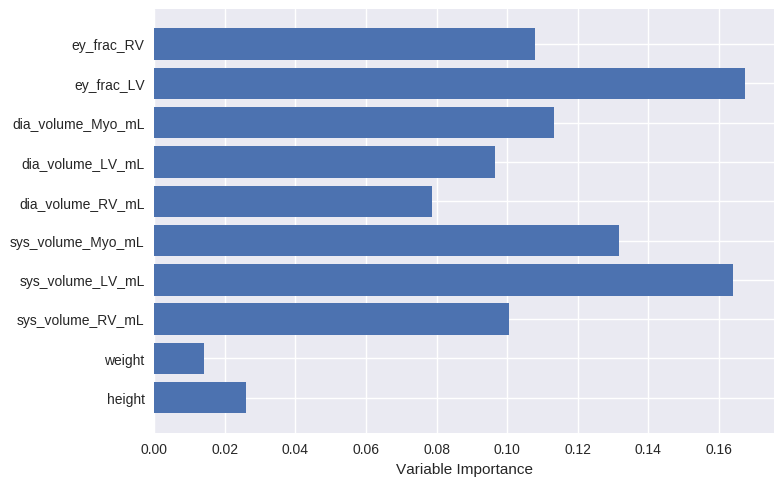

In [131]:
var_importance=best_rf.feature_importances_.tolist()
plt.style.use('seaborn')
plt.barh(X.columns.tolist(), var_importance)
plt.xlabel('Variable Importance')

#### Las 3 variables con mayor importancia en el modelo son:
    · Fracción de eyección del ventrículo izquierdo (ey_frac_LV)
    · Volumen del ventriculo izquierdo en sístole (sys_volume_LV_mL)
    · Volumen de miocardio en sístole (sys_volume_Myo_mL)

#### Una vez construido el modelo con los mejores hiperparámetros predecimos la categoría a la que pertenece cada paciente

In [11]:
y_test_hat = best_rf.predict(X_test)

# 4.Visualización de resultados

#### Para facilitar la visualización de los resultados se crea la matriz de confución con los valores predichos y observados

In [12]:
from mlxtend.plotting import plot_confusion_matrix

(<Figure size 432x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f4d0c49d2e8>)

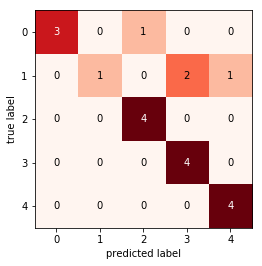

In [13]:
plot_confusion_matrix(confusion_matrix(y_test, y_test_hat), cmap = "Reds")

#### A partir de la matriz de confusión se estiman distintas métricas de la calidad de ajuste del modelo

In [14]:
print(classification_report(y_test, y_test_hat))

             precision    recall  f1-score   support

        DCM       1.00      0.75      0.86         4
        HCM       1.00      0.25      0.40         4
       MINF       0.80      1.00      0.89         4
        NOR       0.67      1.00      0.80         4
         RV       0.80      1.00      0.89         4

avg / total       0.85      0.80      0.77        20



#### Con los mejores parámetros para el modelo se estima la probabilidad de sufrir cada una de las 5 patologías

In [15]:
probabs = best_rf.predict_proba(X)

In [16]:
print(probabs)

[[0.71787302 0.07699603 0.17234921 0.03278175 0.        ]
 [0.5205119  0.2025     0.27032143 0.00666667 0.        ]
 [0.97704762 0.002      0.01720238 0.         0.00375   ]
 [0.84565476 0.04066667 0.1027619  0.00666667 0.00425   ]
 [0.79027381 0.07302381 0.11658333 0.01392857 0.00619048]
 [0.90766667 0.0085     0.04770238 0.01904762 0.01708333]
 [0.97883333 0.00666667 0.00491667 0.         0.00958333]
 [0.86832143 0.02917857 0.07234524 0.02396429 0.00619048]
 [0.83367857 0.05533333 0.10365476 0.00633333 0.001     ]
 [0.95504762 0.002      0.01753571 0.00166667 0.02375   ]
 [0.80967857 0.         0.15839286 0.01909524 0.01283333]
 [0.62582143 0.03592857 0.32841667 0.00716667 0.00266667]
 [0.91846429 0.028      0.05228571 0.         0.00125   ]
 [0.9727619  0.         0.02015476 0.         0.00708333]
 [0.08661905 0.01295238 0.82325    0.03122222 0.04595635]
 [0.96629762 0.         0.01995238 0.         0.01375   ]
 [0.8467381  0.005      0.08988095 0.01971429 0.03866667]
 [0.49571032 0

In [17]:
probabs_df = pd.DataFrame(probabs)
probabs_df.columns=best_rf.classes_

In [18]:
train.reset_index(drop=True, inplace=True)

In [19]:
final_train = pd.concat([train, probabs_df], axis = 1)

In [21]:
final_train

,height,weight,sys_volume_RV_mL,sys_volume_LV_mL,sys_volume_Myo_mL,dia_volume_RV_mL,dia_volume_LV_mL,dia_volume_Myo_mL,patology,ey_frac_LV,ey_frac_RV,DCM,HCM,MINF,NOR,RV
0,184.0,95.0,67.089844,228.369141,196.777344,146.289062,297.241211,177.612305,DCM,0.231704,0.541389,0.717873,0.076996,0.172349,0.032782,0.000000
1,160.0,70.0,33.028793,182.957458,204.584122,99.348068,255.314255,172.209549,DCM,0.283403,0.667545,0.520512,0.202500,0.270321,0.006667,0.000000
2,165.0,77.0,177.368164,245.239258,200.683594,189.306641,275.952148,196.020508,DCM,0.111298,0.063064,0.977048,0.002000,0.017202,0.000000,0.003750
3,159.0,46.0,87.852478,227.444458,182.209778,107.740784,264.192963,166.115952,DCM,0.139097,0.184594,0.845655,0.040667,0.102762,0.006667,0.004250
4,165.0,77.0,87.980713,224.846191,233.745117,168.822510,288.107666,202.757080,DCM,0.219576,0.478857,0.790274,0.073024,0.116583,0.013929,0.006190
5,180.0,70.0,181.006622,279.636383,203.408432,280.872345,335.409164,203.130341,DCM,0.166283,0.355556,0.907667,0.008500,0.047702,0.019048,0.017083
6,173.0,107.0,232.031250,279.527344,197.015625,303.363281,315.914062,193.007812,DCM,0.115179,0.235137,0.978833,0.006667,0.004917,0.000000,0.009583
7,180.0,100.0,95.288086,237.890625,196.313477,168.896484,283.203125,180.590820,DCM,0.160000,0.435820,0.868321,0.029179,0.072345,0.023964,0.006190
8,153.0,61.0,67.945729,229.034118,214.846826,86.675198,262.418182,204.603563,DCM,0.127217,0.216088,0.833679,0.055333,0.103655,0.006333,0.001000
9,170.0,68.0,209.667969,266.723633,168.676758,282.031250,302.856445,173.046875,DCM,0.119307,0.256579,0.955048,0.002000,0.017536,0.001667,0.023750


#### Mediante la siguiente función visualizamos la probabilidad de un determinado paciente de sufrir cada una de las enfermedades

In [105]:
import matplotlib.pyplot as plt
def plot_proba(values, names, style='seaborn', xlabel='', ylabel='', 
                        titulo=''):
  color=['cornflowerblue', 'cornflowerblue', 'cornflowerblue', 'cornflowerblue', 
         'cornflowerblue']
  i=values.index(max(values)) 
  color[i]='darkblue'
  y_pos = np.arange(len(names))

  plt.style.use(style)
  plt.barh(names, values, align='center', alpha=0.9, color=color)
  plt.xlim(0, 1)
  plt.yticks(y_pos, names)
  plt.xlabel(xlabel)
  plt.ylabel(ylabel)
  plt.title(titulo)
  
  plt.show()

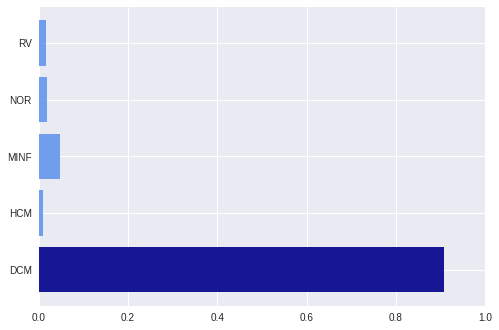

In [106]:
num_patient=5
valores=final_train.iloc[num_patient,-5:].values.tolist()
enfermedades=final_train.iloc[num_patient,-5:].index
plot_proba(valores, enfermedades)